In [94]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

url = 'crowd_change1.csv'
#df1 = pd.read_csv(url)
# series = read_csv(url, header=0, index_col=0, parse_dates=True, squeeze=True)
series = read_csv(url, header=0, index_col=0, parse_dates=True)
series
# print(series)

,Current Total Count
Time,
2005-07-24 00:00:00,0
2005-07-24 00:30:00,-1
2005-07-24 01:00:00,-1
2005-07-24 01:30:00,-1
2005-07-24 02:00:00,-1
...,...
2005-11-04 21:30:00,42
2005-11-04 22:00:00,42
2005-11-04 22:30:00,41


In [95]:
df = pd.read_csv('LSTM/crowd_change.csv', engine='python')

# interpolation for "Time"
df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)
for dd in df['Time'].index:
  if dd%2 == 1:
    df['Time'].iloc[dd].values = df['Time'].iloc[dd] + pd.DateOffset(minutes=15)

df.index = df['Time']
df.drop(columns=['Time'], inplace=True)
timeseries = df[["Current Total Count"]].values.astype('float32')


/tmp/ipykernel_718620/2702083590.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'], yearfirst=True)


In [96]:
series = df['Current Total Count']
series

Time
2005-07-24 00:00:00     0
2005-07-24 00:00:00     0
2005-07-24 00:30:00    -1
2005-07-24 00:30:00    -1
2005-07-24 01:00:00    -1
                       ..
2005-11-05 22:30:00   -23
2005-11-05 23:00:00   -23
2005-11-05 23:00:00   -23
2005-11-05 23:30:00   -24
2005-11-05 23:30:00   -24
Name: Current Total Count, Length: 10080, dtype: int64

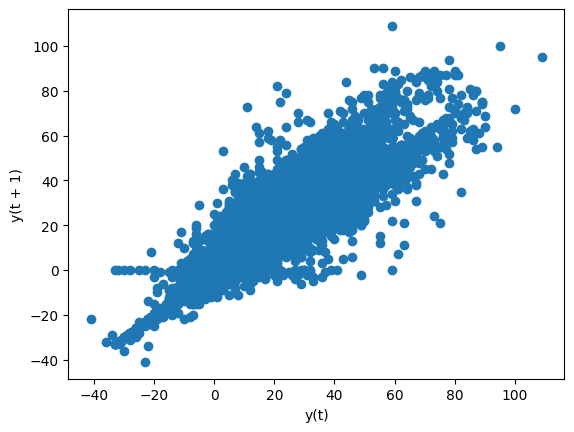

In [97]:
from pandas.plotting import lag_plot
# series = read_csv(url, header=0, index_col=0)
lag_plot(series)
plt.show()

In [98]:
from pandas import concat
# series = read_csv(url, header=0, index_col=0)
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.926471
t+1  0.926471  1.000000


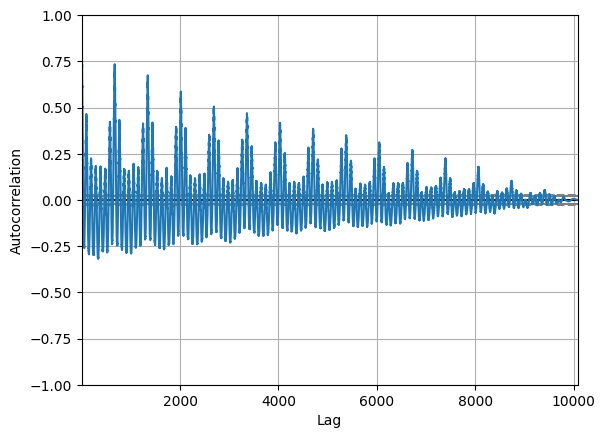

In [99]:
from pandas.plotting import autocorrelation_plot
# series = read_csv(url, header=0, index_col=0)
autocorrelation_plot(series)
plt.show()

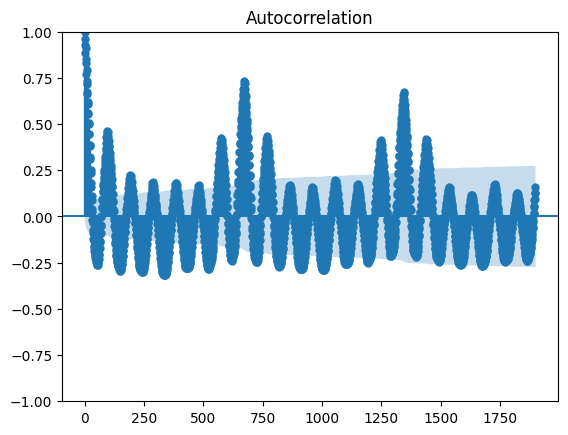

In [100]:
from statsmodels.graphics.tsaplots import plot_acf
# series = read_csv(url, header=0, index_col=0)
plot_acf(series, lags=1900)
plt.show()

In [136]:
# split dataset
X = series.values
# train, test = X[1:len(X)-48], X[len(X)-48:]

# train-test split for time series
train_size = int(len(series) * 0.8)
test_size = len(series) - train_size
train, test = series.values[:train_size], series.values[train_size:]


from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# train autoregression
# model = AutoReg(train, lags=500)
model = AutoReg(train, lags=1500)
# model = AutoReg(train, lags=3000)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
further_pred_length: int = 500
predictions = model_fit.predict(start=len(train),
                                end=len(train)+len(test)-1+further_pred_length,
                                # dynamic=False,
                                dynamic=True,
                                )
# for i in range(len(predictions)):
	# print('predicted=%f, expected = %d' % (predictions[i], test[i]))
for i in range(len(test)):
  if i % 30 == 0:
    print(f'[{i}] predicted={predictions[i]}, expected = {test[i]}')
rmse = sqrt(mean_squared_error(test, predictions[:len(test)]))
print('Test RMSE: %.3f' % rmse)

Coefficients: [ 0.54041321  0.75085751  0.3452387  ...  0.01724893 -0.00935631
 -0.01133593]
[0] predicted=-19.45180360871274, expected = -3
[30] predicted=-1.5931829588446458, expected = -4
[60] predicted=-3.1006001947178268, expected = -11
[90] predicted=-6.038828939485876, expected = -33
[120] predicted=-1.0349773618617468, expected = -1
[150] predicted=32.49147433518347, expected = 54
[180] predicted=37.33581631433783, expected = 47
[210] predicted=5.895204617367252, expected = -5
[240] predicted=22.178708537795128, expected = 9
[270] predicted=37.3445444648168, expected = 7
[300] predicted=-1.5409756566493045, expected = 0
[330] predicted=9.647376632504606, expected = 28
[360] predicted=23.224608986652644, expected = 56
[390] predicted=-4.144314152673582, expected = -3
[420] predicted=-1.902302613942376, expected = 2
[450] predicted=30.879074103053807, expected = 31
[480] predicted=-5.189050525879201, expected = -1
[510] predicted=1.1070518481590566, expected = -7
[540] predicted=

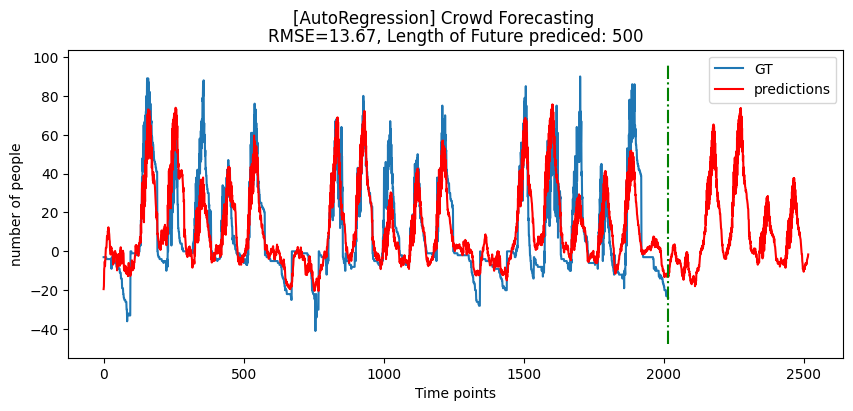

In [137]:
# plot results
fig, ax = plt.subplots(figsize=(10, 4))
fig.suptitle('[AutoRegression] Crowd Forecasting')
ax.set_title(f'RMSE={rmse:.2f}, Length of Future prediced: {further_pred_length}')
ax.set_xlabel('Time points')
ax.set_ylabel('number of people')
ax.plot(test, label='GT')
ax.plot(predictions, color='red', label='predictions')
y_lower, y_upper = ax.get_ybound()
ax.vlines(x=len(test), ymin=y_lower, ymax=y_upper, colors='g', linestyles='dashdot')
ax.legend()
plt.show()